# Statistical Insights into Chinook's database with SQLite

In this project I will analyze the famous sample database of a digital media store called Chinook. The database contains 11 tables and the connections between the tables can be found on the following image. 

![Chinook database](chinook-schema.svg)

First, let's import the libraries and create some helper functions.

In [1]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [25]:
# returns the output as pandas dataframe
def run_query(q):
    with sqlite3.connect('chinook.db') as conn:
        return pd.read_sql(q, conn)

In [3]:
def run_command(c):
    with sqlite3.connect('chinook.db') as conn:
        conn.isolation_level = None
        conn.execute(c)

In [26]:
def show_tables():
    q = '''SELECT name, type 
           FROM sqlite_master 
           WHERE type IN ("table","view")'''
    return run_query(q)


# let's check what the database contains
if __name__ == '__main__':
    print(show_tables())

              name   type
0            album  table
1           artist  table
2         customer  table
3         employee  table
4            genre  table
5          invoice  table
6     invoice_line  table
7       media_type  table
8         playlist  table
9   playlist_track  table
10           track  table


Using the information saved in this database, I will answer the following questions:
1. What are the best-selling genres in USA?
2. Which employee has the biggest number of clients and sales?
3. Which countries should Chinook's marketing team direct their attention to?

## 1. Best-selling genres in USA. 

Before signing contracts with new artists to buy the rights to sell their albums in Chinook's store in USA, it is important for management to understand which genres are most popular in the store righ now. I will create a query to display 10 top-selling genres among Chinook's customers and will also visualize the output.

           genre_name  number_of_tracks  track_percentage
0                Rock               561          0.533777
1  Alternative & Punk               130          0.123692
2               Metal               124          0.117983
3            R&B/Soul                53          0.050428
4               Blues                36          0.034253
5         Alternative                35          0.033302
6               Latin                22          0.020932
7                 Pop                22          0.020932
8         Hip Hop/Rap                20          0.019029
9                Jazz                14          0.013321


Text(0,0.5,'Tracks Sold')

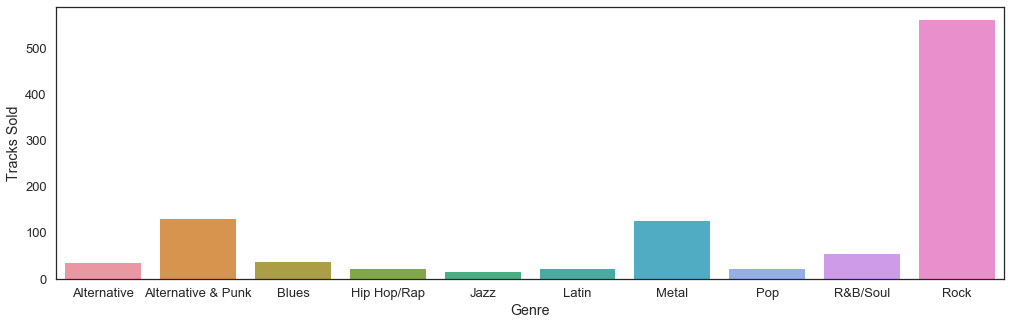

In [40]:
q = '''WITH 
        tracks_usa AS -- create a table consisting of tracks only sold in USA
        (
        SELECT il.track_id FROM invoice_line il
        LEFT JOIN invoice i ON i.invoice_id = il.invoice_id
        WHERE i.billing_country = 'USA'
        ),
        
        genre_tracks AS -- combine with previous table to count number of popular tracks
        (
         SELECT 
             g.name genre_name, 
             COUNT(tu.track_id) number_of_tracks
         FROM genre g
         LEFT JOIN track t
         ON t.genre_id = g.genre_id
         LEFT JOIN tracks_usa tu
         ON tu.track_id = t.track_id
         GROUP BY genre_name
        )
        
        SELECT
            genre_name,
            number_of_tracks,
            (CAST(number_of_tracks as Float) /1051) track_percentage
        FROM genre_tracks
        ORDER BY 2 DESC
        LIMIT 10
        '''

if __name__ == '__main__':
    print(run_query(q))

genre_sales_usa = run_query(q)

genre_sales_usa.genre_name = genre_sales_usa.genre_name.astype('category')

fig, ax = plt.subplots(figsize=(17,5))



sns.barplot(x='genre_name', y='number_of_tracks', data=genre_sales_usa, ax=ax)
ax.set_xlabel('Genre')
ax.set_ylabel('Tracks Sold')

According to the table and the barplot above, Chinook should definitely buy albums of new rock artists, since it is the most popular genre in USA. In addition, they should also consider buying albums in Alternative & Punk, Metal and R&B/Soul genres, since they compose more than 5% of total sales. However, while considering other genres, the management should collect another more up-to-date data to see whether there has been a change in customers' preferences.

## 2. Employee performance

Since every customer in Chinook is assigned to a sales support agent, we can analyze employee performance. Moreover, I will break this question into 2 parts. First, I want to compare the total sales of each of employees. Second, I will create a query of all sales ever placed in Chinook in order to visualize the employee performence with boxplot.

#### 2. 1 - Total Sales

   employee_id  employee_name  number_of_clients  total_sales
0            3   Jane Peacock                 21      1731.51
1            4  Margaret Park                 20      1584.00
2            5  Steve Johnson                 18      1393.92


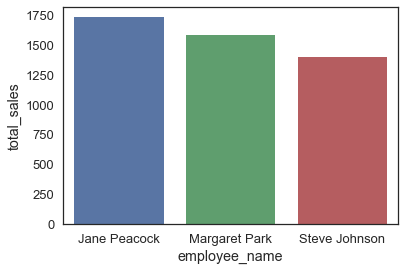

In [46]:
q = '''WITH
            employee_customer AS 
            (
             SELECT 
                e.employee_id,
                (e.first_name || ' ' || e.last_name) employee_name,
                c.customer_id
             FROM employee e
             INNER JOIN customer c ON e.employee_id = c.support_rep_id
            ),
            customer_total AS
            (
             SELECT 
                 c.customer_id,
                 SUM(i.total) total_purchased
             FROM customer c
             LEFT JOIN invoice i ON c.customer_id = i.customer_id
             GROUP BY 1
            )
       SELECT
           ec.employee_id, 
           ec.employee_name,
           COUNT(ec.customer_id) number_of_clients,
           SUM(ct.total_purchased) total_sales
       FROM employee_customer ec
       LEFT JOIN customer_total ct ON ec.customer_id = ct.customer_id
       GROUP BY 1,2
           
    '''
if __name__ == '__main__':
    print(run_query(q))

employee_total_sales = run_query(q)
employee_total_sales.employee_name=employee_total_sales.employee_name.astype('category')

fig, ax = plt.subplots()
sns.barplot(x='employee_name', y='total_sales', data=employee_total_sales, ax=ax)

According to the barplot Jane Peacock has the biggest total sales, while Steve Johnson the smallest. Moreover, Jane has the biggest number of customers, wherea Steve the smallest.

#### 2.2 Every sale

     customer_id  total  support_rep_id  employee_name
0              1   8.91               3   Jane Peacock
1              1   5.94               3   Jane Peacock
2              1   8.91               3   Jane Peacock
3              1  13.86               3   Jane Peacock
4              1   5.94               3   Jane Peacock
5              1   0.99               3   Jane Peacock
6              1  17.82               3   Jane Peacock
7              1  10.89               3   Jane Peacock
8              1  12.87               3   Jane Peacock
9              1   3.96               3   Jane Peacock
10             1   3.96               3   Jane Peacock
11             1   5.94               3   Jane Peacock
12             1   8.91               3   Jane Peacock
13             2  13.86               5  Steve Johnson
14             2   2.97               5  Steve Johnson
15             2   7.92               5  Steve Johnson
16             2   8.91               5  Steve Johnson
17        

Text(0,0.5,'Invoice Total')

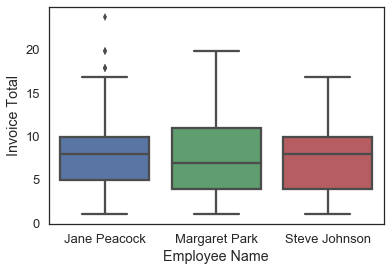

In [49]:
q = ''' SELECT 
            i.customer_id,
            i.total,
            c.support_rep_id,
            (e.first_name || ' ' || e.last_name) employee_name
        FROM invoice i
        INNER JOIN customer c
        ON i.customer_id = c.customer_id
        INNER JOIN employee e
        ON c.support_rep_id = e.employee_id
        ORDER BY i.customer_id
    
    '''

if __name__ == '__main__':
    print(run_query(q))

customer_purchases = run_query(q)
customer_purchases.employee_name = customer_purchases.employee_name.astype('category')

fig, ax = plt.subplots()
sns.boxplot(x='employee_name', y='total', data = customer_purchases, ax=ax)
ax.set_xlabel('Employee Name')
ax.set_ylabel('Invoice Total')

According to the boxplot above, Jane Peacock and Steve Johnson have approximately the same median in sales (around \$8 per invoice) and the overall distribution in sales. However, Jane Peacock has more outliers, which means that there were days when she sold much more tracks than usually. Hence, this can explain the fact that she has biggest sales among three of them. Next, although Margaret Park's median sales are lower than others' (around \$7 per invoice), she has the biggest variations in both third and fourth quartiles. Thus, the fact that 25% of her sales vary from \$11 to \$20 explains why her total sales are bigger than Steve's.

## 3. Sales by country

It is important for marketing team to know as many details as possible about their actual or potential audience. In particular, location of the customers, since their nationality and culture influences their prefences significantly. 

In [9]:
q = '''WITH customers_total AS
       (
        SELECT
           customer_id,
           SUM(total) total_purchased,
           AVG(total) avg_per_invoice
        FROM invoice
        GROUP BY 1
        ORDER BY 1
       ),
       
       country_statistics AS
       (
        SELECT
           c.country,
           COUNT(ct.customer_id) number_of_customers,
           SUM(ct.total_purchased) total_purchased,
           AVG(ct.total_purchased) avg_per_customer,
           AVG(ct.avg_per_invoice) avg_per_invoice
        FROM customer c
        LEFT JOIN customers_total ct
        ON c.customer_id = ct.customer_id
        GROUP BY 1
       ),
       
       country_statistics_other AS
       (
        SELECT 
            CASE
                WHEN number_of_customers = 1 THEN 'other'
                ELSE country
                END
                AS country_other,
            *
       FROM country_statistics
       ),
       
       full_country_statistics_other AS
       (
        SELECT
            country_other,
            SUM(number_of_customers) number_of_customers,
            SUM(total_purchased) total_purchased,
            SUM(avg_per_customer) avg_per_customer,
            SUM(avg_per_invoice) avg_per_invoice
        FROM country_statistics_other
        GROUP BY 1
        ORDER BY 3 DESC
       )
       
       SELECT 
           country_other,
           number_of_customers,
           total_purchased,
           avg_per_customer,
           avg_per_invoice
       FROM
           (
            SELECT fcso.*,
                   CASE
                       WHEN country_other = 'other' THEN 1
                       ELSE 0
                       END
                       AS sort
            FROM full_country_statistics_other fcso
           )
       ORDER BY sort
    '''

if __name__ == '__main__':
    print(run_query(q))

df_country = run_query(q)

    country_other  number_of_customers  total_purchased  avg_per_customer  \
0             USA                   13          1040.49         80.037692   
1          Canada                    8           535.59         66.948750   
2          Brazil                    5           427.68         85.536000   
3          France                    5           389.07         77.814000   
4         Germany                    4           334.62         83.655000   
5  Czech Republic                    2           273.24        136.620000   
6  United Kingdom                    3           245.52         81.840000   
7        Portugal                    2           185.13         92.565000   
8           India                    2           183.15         91.575000   
9           other                   15          1094.94       1094.940000   

   avg_per_invoice  
0         8.014750  
1         7.416238  
2         6.987485  
3         7.835000  
4         8.188750  
5         9.377500  
6    

In [10]:
df_country.drop(9, axis=0, inplace=True)

In [11]:
df_country.country_other = df_country.country_other.astype('category')

Let's plot barplots for every column.

Text(0.5,0,'')

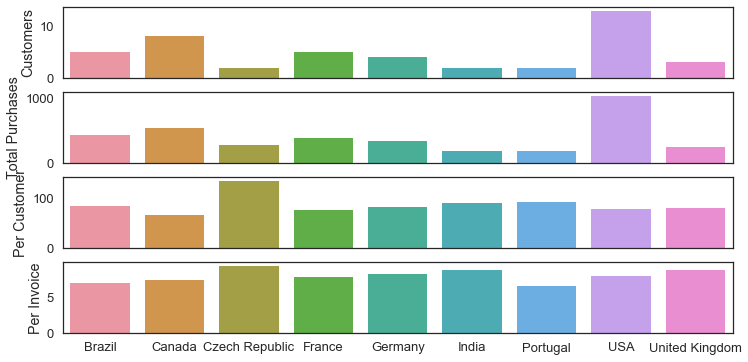

In [51]:
sns.set(context='talk', style = 'white')
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(12, 6), sharex=True)

#first subplot
sns.barplot(x='country_other', y='number_of_customers', data=df_country, ax=ax1)
ax1.set_ylabel('Customers')
ax1.set_xlabel('')

#seo=cond subplot
sns.barplot(x='country_other', y='total_purchased', data=df_country, ax=ax2)
ax2.set_ylabel('Total Purchases')
ax2.set_xlabel('')

#first subplot
sns.barplot(x='country_other', y='avg_per_customer', data=df_country, ax=ax3)
ax3.set_ylabel('Per Customer')
ax3.set_xlabel('')

#first subplot
sns.barplot(x='country_other', y='avg_per_invoice', data=df_country, ax=ax4)
ax4.set_ylabel('Per Invoice')
ax4.set_xlabel('')

We can conclude that most of Chinook's customers are from USA and Canada. Moreover, these two countries have the largest number of total purchases. However, despite the fact that USA and Canada provide the biggest amount of profits, customers from Czech Republic on average spend much more than US and Canadian customers. In particular, every Czech client spent around \$150 in Chinook with average of \$10 per invoice, while typical US customer would not spent more than \$150 in store and around \$8 per invoice. Hence, in order to boost their sales, Chinook should consider improving their advertisement campaign in Czech Republic, so that they will attract more customers who are willing to spend more on buying tracks from Chinook. Nevertheless, it should be noted that were only 2 customers from Czech Republic in the sample, so it would be useful to collect more data before investing money in marketing in Europe.